In [16]:
import numpy as np
import random
import copy
import globals as gb
from tqdm.auto import tqdm
from dataclasses import dataclass
from tree import Tree, swap_subtrees, generate_initial_solution
from utils import mse, sort_individuals, compute_score
from mutations import mutation

## Problem selection

In [17]:
gb.initialize_globals_for_problem(1)

POPULATION_SIZE = gb.PROBLEM_SIZE * 20
OFFSPRING_SIZE = int(POPULATION_SIZE / 4)
MAX_ITERATIONS = POPULATION_SIZE * 50

## Steps
- We treat a possible solution as a tree. The tree has attribute root, which is the root of the tree of class TreeNode and max_depth.
- Generate random tree
    - we need each variable at least once 
    - each variable has exactly one coefficient chosen as a random float number in the range [?, ?]
    - each variable has exactly one unary operator
    - unary operator is chosen as: 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among all other unary operators
        - check if the unary operator is appliable to the variable ->
            ```
            leaves_map = {}
            for e in leaves:
                available_unary_operators = [op for op in list(UNARY_OPERATORS.keys()) if op.is_applicable(e)]
                chosen_unary_operator = 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among [available_unary_operators]
                leaves_map[e] = [chosen_unary_operator]
            # leaves = [-2, 3]
            # leaves_map = {-2: square, 3: log}
            for e in leaves:
                node = leaves_map[e]
                node.left = null
                node.right = e
                # insert node to tree
            ```
    - number of leaves = nearest power of two greater than keys.length()
    - number of actual leaves = [number of leaves] * 2
    - number of coefficients = [number of leaves] - keys.length()
    - number of binrary operators = total number of nodes in  tree with [number of leaves] leaves - [number of leaves]]
    - validate tree
    - if valid, return tree
    - else, ?
- Example:
    - x.length() = 3
    - number of leaves = 4
    - number of actual leaves = 8
    - number of coefficients = 1
    - number of operands = 3

    ```bash
                    +
            /                  \
            *                    +
        /      \           /        \
      u        1          1          u
    /   \    /   \      /   \       /  \
    nul  *  nul   *    nul    *     nul *
    ```
### EA approach
- Individual is rapresented as a tree and a fitness
    - fitness is a tuple of 2 values: (-mse, right_sign_100)
        - right_sign_100 is the percentage of correct sign predictions
        - mse is the mean squared error
- Classic Genetic Programming
    - Key elements 
    - Representation: tree structures
    - Recombination: exchange of subtrees
    - Mutation: random change in trees
        - subtree mutation -> replace  entire subtree
        - point  mutation -> change single node
        - permutation -> exchange node right with left
        - hoist -> take subtree and make it root
        - expansion -> take random leaf and replace it with a new subtree
        - collapse -> take a subtree and replace it with leaf
    - Population model: generational
    - Parent selection: fitness proportional
    - Survivor selection: deterministic

##next

    - finish implementing mutations
    - find way to reduce tree dimension
    - add weights to opertors
    - add check if fitness doesn't improve , stop early
    - 

##problems
    - overflow
    - initial tree with 4xnodes has invalid values
    - 


## Individual definition

In [18]:
@dataclass
class Individual:
    genome: Tree
    fitness: tuple

## Fitness evaluation

In [19]:
def fitness(sol: Tree):
    y_computed = sol.root.evaluate_tree_from_node()
    right_sign_100 = 100 * np.sum(np.sign(y_computed) == np.sign(gb.Y)) / len(gb.Y)
    return  -mse(y_computed, gb.Y) * (np.exp((sol.get_max_depth() / 10))), right_sign_100

## EA helper functions

In [20]:
def parent_selection(population: list[Individual], scores, worst_score):
    # windowing    
    scores_prime = [(s-worst_score) for s in scores]
    # print(len(population), len(scores))
    total = sum(scores_prime)
    # if all population doesn't have some score
    if total != 0:
        probabilities = [s/total for s in scores_prime]

        parents = random.choices(population, probabilities, k=2)
            
        return parents[0], parents[1]
    
    return population[0], population[1]

def xover(parent1, parent2)-> tuple[Tree, tuple]:
    # parents = random.choices(population, k=2)

    # reproduce
    c1 = copy.deepcopy(parent1.genome)
    c2 = copy.deepcopy(parent2.genome)

    success = swap_subtrees(c1, c2)

    c_fitness = fitness(c2)

    if not success:
        # mutation
        mutation(c2)

    return c2, c_fitness

def tournament(population):
    # generate a certain number of tournaments
    n_tour = 3
    winners = []
    # for each tournament find a winner for a portion of the population
    for i in range(n_tour):
        start =int( i*len(population)/3)
        end =int( (i+1)*len(population)/ 3)
        p_i = population[start : end]

        w_i = ea(p_i)
        winners.append(w_i)
    
    winners , scores = sort_individuals(winners)
    # get the best winner/s
    # check if there are pari merito
    # best_score = np.max(scores)

    # return [winners[i] for i in range(len(winners)) if scores[i]==best_score]
    return winners



# n. torunament --> population / #tour --> ea
# n.tour winners --> take best
# generate initial population from best with mutations

def ea(population, iterations=200, best=None, best_score=-1, prev_score=0):
    # print(population)
    scores = []
    offsprings = []
    worst_score = 0
    
    for ind in population:
        ind.fitness = fitness(ind.genome)
    population, scores = sort_individuals(population)

    for i in tqdm(range(iterations)):
    
        for _ in range(OFFSPRING_SIZE):
            parent1, parent2 = parent_selection(population, scores, worst_score)
            # crossover
            if random.random() < 0.8:
                child, c_fitness = xover(parent1, parent2)
        
                offsprings.append(Individual(child, c_fitness))

            # mutation
            else :
                # take a random individual and mutate it
                ind = copy.deepcopy(random.choice([parent1,parent2]))

                mutation(ind.genome)
                # recompute fitness
                ind.fitness = fitness(ind.genome)
                offsprings.append(ind)
        population.extend(offsprings)
        offsprings = []

        if i % 100 == 0:
            #print(f"iteration {i} best individual : {population[0].fitness}")
            # compute score 
            score = scores[0]
            if score > best_score:
                #print(f"new best score : {score}, old score : {best_score}")
                best = population[0]
                best_score = score

            # put again the best one in population
            else: 
                #print("valhalla")
                population.append(best)
                population,scores = sort_individuals(population)
                # print(f"valhallla {i}: scores {scores}\n")

            worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score
        
        
        # sort population according to score based on fitness         
        population, scores = sort_individuals(population)

        # remove worst individual
        population = population[:POPULATION_SIZE]
        scores = scores[:POPULATION_SIZE]

           # stop searching if scores doesn't improve anymore after 20% of max iterations
        if i % (MAX_ITERATIONS*0.25) == 0:
            if prev_score == scores[0]:
                print("exit")
                break
            else:
                prev_score = scores[0]


    print(f"winner's mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)}")
    
    return population[0]

## Main

In [21]:
# state = random.getstate()
# population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(gb.POPULATION_SIZE)]
# offsprings = []
# random.setstate(state)

# winners = tournament(population)
# winners

  0%|          | 0/200 [00:00<?, ?it/s]

winner's mse 0.06058601596535469


  0%|          | 0/200 [00:00<?, ?it/s]

winner's mse 0.028186064131489375


  0%|          | 0/200 [00:00<?, ?it/s]

winner's mse 0.9722227033844891


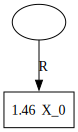

  0%|          | 0/200 [00:00<?, ?it/s]

winner's mse 0.031209213100795163
Best individual has formula:
Best individual mse 0.031209213100795163


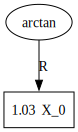

In [22]:
state = random.getstate()
population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]
offsprings = []
random.setstate(state)

# torunament -> use initial population
winner = tournament(population)
#generate population from winner

# set the fitness
for ind in population:
    ind.fitness = fitness(ind.genome)
population, scores = sort_individuals(population)
population[0].genome.draw_tree()

# ea
result = ea(population)
print("Best individual has formula:")
print(f"Best individual mse {mse(result.genome.root.evaluate_tree_from_node(), gb.Y)}")
result.genome.draw_tree()

# # print(population)

# best = None
# best_score = -1
# worst_score = 0

# prev_score = 0 #score to check every 10% of iterations
# scores = [compute_score(population[i], population) for i in range(POPULATION_SIZE)]

# for i in tqdm(range(MAX_ITERATIONS)):
    
#     for _ in range(OFFSPRING_SIZE):
#         parent1, parent2 = parent_selection(population, scores, worst_score)
#         # crossover
#         if random.random() < 0.65:
#             child, c_fitness = xover(parent1, parent2)
    
#             offsprings.append(Individual(child, c_fitness))

#         # mutation
#         else :
#             # take a random individual and mutate it
#             ind = copy.deepcopy(random.choice([parent1,parent2]))

#             mutation(ind.genome)
#             # recompute fitness
#             ind.fitness = fitness(ind.genome)
#             offsprings.append(ind)
#     population.extend(offsprings)
#     offsprings = []
    
#     # sort population according to score based on fitness         
#     population, scores = sort_individuals(population)
#     # print(f"{i}: scores {scores}\n")

#     if i % 100 == 0:
#         #print(f"iteration {i} best individual : {population[0].fitness}")
#         # compute score 
#         score = scores[0]
#         if score > best_score:
#             #print(f"new best score : {score}, old score : {best_score}")
#             best = population[0]
#             best_score = score

#         # put again the best one in population
#         else: 
#             #print("valhalla")
#             population.append(best)
#             population,scores = sort_individuals(population)
#             # print(f"valhallla {i}: scores {scores}\n")

#         worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score
   
   
#     # remove worst individual
#     population = population[:POPULATION_SIZE]
#     scores = scores[:POPULATION_SIZE]
    
#     # stop searching if scores doesn't improve anymore after 20% of max iterations
#     if i % (MAX_ITERATIONS*0.25) == 0:
#         if prev_score == scores[0]:
#             print("exit")
#             break
#         else:
#             prev_score = scores[0]

    



## version 2

In [23]:
""" POPULATION_SIZE = PROBLEM_SIZE*20
OFFSPRING_SIZE = POPULATION_SIZE*3
MAX_ITERATIONS = 1000 """

' POPULATION_SIZE = PROBLEM_SIZE*20\nOFFSPRING_SIZE = POPULATION_SIZE*3\nMAX_ITERATIONS = 1000 '

In [24]:
""" state = random.getstate()
initial_population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]
offsprings = []
random.setstate(state)

# set the fitness
for ind in initial_population:
    ind.fitness = fitness(ind.genome)
initial_population, scores = sort_individuals(initial_population)
initial_population[0].genome.draw_tree()

# print(initial_population)

best = None
best_score = 0
worst_score = 0
scores = [compute_score(initial_population[i], initial_population) for i in range(POPULATION_SIZE)]

for i in tqdm(range(MAX_ITERATIONS)):
# for i in range(MAX_ITERATIONS):
    for _ in range(OFFSPRING_SIZE):
        parent1, parent2 = parent_selection(initial_population, scores, worst_score)
        # crossover
        if random.random() < 0.65:
            child, c_fitness = xover(parent1, parent2)
    
            offsprings.append(Individual(child, c_fitness))

        # mutation
        else :
            # take a random individual and mutate it
            ind = copy.deepcopy(random.choice([parent1,parent2]))

            mutation(ind.genome)
            # recompute fitness
            ind.fitness = fitness(ind.genome)
            offsprings.append(ind)

    
    # sort population according to score based on fitness         
    initial_population, scores = sort_individuals(offsprings)
    # print(f"{i}: scores {scores}\n")

    if i % 100 == 0:
        print(f"iteration {i} best individual : {initial_population[0].fitness}")
        # compute score 
        score = scores[0]
        if score > best_score:
            print(f"new best score : {score}, old score : {best_score}")
            best = initial_population[0]
            best_score = score

        # put again the best one in population
        else: 
            print("valhalla")
            initial_population.append(best)
            initial_population,scores = sort_individuals(initial_population)
            print(f"valhallla {i}: scores {scores}\n")

        worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score
   
   
    # remove worst individual
    initial_population = initial_population[:POPULATION_SIZE]
    scores = scores[:POPULATION_SIZE]
    # print(f"cut {i}: scores {scores}\n")
 
    # update the worst score
    # print(f"iteration {i} ")
    offsprings = []

print("Best individual has formula:")
print(f"Best individual mse {mse(initial_population[0].genome.root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), y)}")
initial_population[0].genome.draw_tree() """

' state = random.getstate()\ninitial_population = [Individual(generate_initial_solution(seed=(i+2) * 10), 0) for i in range(POPULATION_SIZE)]\noffsprings = []\nrandom.setstate(state)\n\n# set the fitness\nfor ind in initial_population:\n    ind.fitness = fitness(ind.genome)\ninitial_population, scores = sort_individuals(initial_population)\ninitial_population[0].genome.draw_tree()\n\n# print(initial_population)\n\nbest = None\nbest_score = 0\nworst_score = 0\nscores = [compute_score(initial_population[i], initial_population) for i in range(POPULATION_SIZE)]\n\nfor i in tqdm(range(MAX_ITERATIONS)):\n# for i in range(MAX_ITERATIONS):\n    for _ in range(OFFSPRING_SIZE):\n        parent1, parent2 = parent_selection(initial_population, scores, worst_score)\n        # crossover\n        if random.random() < 0.65:\n            child, c_fitness = xover(parent1, parent2)\n    \n            offsprings.append(Individual(child, c_fitness))\n\n        # mutation\n        else :\n            # take